# Extract barrier island metrics along transects

Author: Emily Sturdivant, esturdivant@usgs.gov

***

Extract barrier island metrics along transects for Bayesian Network Deep Dive


## Pre-requisites:
- All the input layers (transects, shoreline, etc.) must be ready. This is performed with the notebook file prepper.ipynb.
- The files servars.py and configmap.py may need to be updated for the current dataset.

## Notes:
- This code contains some in-line quality checking during the processing, which requires the user's attention. For thorough QC'ing, we recommend displaying the layers in ArcGIS, especially to confirm the integrity of values for variables such as distance to inlet (__Dist2Inlet__) and widths of the landmass (__WidthPart__, etc.). 


***

## Import modules

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import arcpy
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import core.functions_warcpy as fwa
import core.functions as fun

### Initialize variables

Based on the project directory, and the site and year you input, setvars.py will set a bunch of variables as the names of folders, files, and fields. Set-up the project folder and paths: 

In [2]:
from core.setvars import *

extendedTrans = os.path.join(home, 'FireIsland_extTrans')
extTrans_tidy = os.path.join(home, 'FireIsland_tidyTrans')

inletLines = os.path.join(home, 'FireIsland2014_inletLines')
ShorelinePts = os.path.join(home, 'FireIsland2014_SLpts')
dlPts = os.path.join(home, 'FireIsland2014_DLpts')
dhPts = os.path.join(home, 'FireIsland2014_DHpts')
armorLines = os.path.join(home, 'FireIsland2014_armorLines')
# elevGrid = os.path.join(home, 'FireIsland2014_DEM')
elevGrid_5m = os.path.join(home, 'FireIsland2014_DEM_5m')

SubType = os.path.join(home, 'FI15_SubType')
VegType = os.path.join(home, 'FI15_VegType')
VegDens = os.path.join(home, 'FI15_VegDens')
GeoSet = os.path.join(home, 'FI15_GeoSet')

# Temporary values
transPts_null = '{}{}_transPts_null'.format(site, year)
extTrans_null = '{}{}_extTrans_null'.format(site, year)

tr_w_anthro = "fiis14_trans_wBen3fields"

site (options: Rockaway, Cobb, Fisherman, Assateague, CapeLookout, Parramore, Cedar, CoastGuard, FireIsland, Forsythe, Assawoman, Monomoy, ParkerRiver, Smith): FireIsland
year (options: 2010, 2012, 2014): 2014
Path to project directory (e.g. \\Macolume\dir\FireIsland2014): ········
setvars.py initialized variables.
SITE: FireIsland
MHW: 0.46
MLW: -1.01
Max dune crest height: 2.5
Projection code: 26918



## Transect-averaged values
We work with the shapefile/feature class as a Pandas Dataframe as much as possible to speed processing and minimize reliance on the ArcGIS GUI display.

1. Create a pandas dataframe from the transects feature class. In the process, we remove some of the unnecessary fields. The resulting dataframe is indexed by __sort_ID__ with columns corresponding to the attribute fields in the transects feature class. 

In [43]:
# Copy feature class to dataframe.
trans_df = fwa.FCtoDF(extendedTrans, id_fld=tID_fld, extra_fields=extra_fields)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

# Display
print("\nHeader of transects dataframe (rows 1-5 out of {}): ".format(len(trans_df)))
trans_df.head()

Converting feature class to array...
Converting array to dataframe...


In [3]:
trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))
trans_df['DD_ID'] = trans_df.index + sitevals['id_init_val']

In [4]:
# Get anthro fields and join to DF
if 'tr_w_anthro' in locals():
    trdf_anthro = fwa.FCtoDF(tr_w_anthro, id_fld=tID_fld, dffields=['Developmen', 'Nourishmen','Construction'])
    trans_df = fun.join_columns(trans_df, trdf_anthro) 
    
trans_df.sample(5)
trans_df.rename(columns={'Developmen':'Development','Nourishmen':'Nourishment'}, inplace=True)

...converting feature class to array...
...converting array to dataframe...


In [22]:
trans_df.columns

Index(['AZIMUTH', 'Arm_Lat', 'Arm_Lon', 'Arm_zMHW', 'CP_x', 'CP_y', 'CP_zMHW',
       'DH_Lat', 'DH_Lon', 'DH_zMHW', 'DL_Lat', 'DL_Lon', 'DL_zMHW', 'LRR',
       'MLW_x', 'MLW_y', 'SL_Lat', 'SL_Lon', 'TRANSECTID', 'TRANSORDER',
       'bh_mhw', 'bh_mlw', 'bw_mhw', 'bw_mlw', 'SL_x', 'SL_y', 'Bslope',
       'DH_x', 'DH_y', 'DH_z', 'DH_snapX', 'DH_snapY', 'DL_x', 'DL_y', 'DL_z',
       'DL_snapX', 'DL_snapY', 'Arm_x', 'Arm_y', 'Arm_z', 'DH_zmhw', 'DL_zmhw',
       'Arm_zmhw', 'DistDL', 'DistDH', 'DistArm', 'uBW', 'uBH', 'ub_feat',
       'Dist2Inlet', 'WidthFull', 'WidthLand', 'WidthPart', 'DD_ID',
       'Construction', 'Development', 'Nourishment', 'mean_Zmhw', 'max_Zmhw'],
      dtype='object')

In [23]:
trans_df.AZIMUTH

sort_ID
1       358.75
2       358.75
3       358.75
4       358.75
5       358.75
6       358.75
7       358.75
8       358.75
9       358.75
10      358.75
11      358.75
12      358.75
13      358.75
14      358.75
15      358.75
16      358.75
17      358.75
18      358.75
19      358.75
20      358.75
21      358.75
22      358.75
23      358.75
24      358.75
25      358.75
26      358.75
27      358.75
28      358.75
29      358.75
30      358.75
         ...  
1073    338.27
1074    338.27
1075    338.27
1076    338.27
1077    338.27
1078    338.27
1079    338.27
1080    338.27
1081    338.27
1082    338.27
1083    338.27
1084    338.27
1085    338.27
1086    338.27
1087    338.27
1088    338.27
1089    338.27
1090    338.27
1091    338.27
1092    338.27
1093    338.27
1094    338.27
1095    338.27
1096    338.27
1097    338.27
1098    338.27
1099    338.27
1100    338.27
1101    338.27
1102    338.27
Name: AZIMUTH, Length: 1102, dtype: float64

### Add XY and Z/slope from DH, DL, SL points within 25 m of transects
Add to each transect row the positions of the nearest pre-created beach geomorphic features (shoreline, dune toe, and dune crest).

Output files for validation:
- pts2trans_SL
- ptSnap2trans_DL
- ptSnap2trans_DH
- arm2trans


#### Shoreline

The MHW shoreline easting and northing (__SL_x__, __SL_y__) are the coordinates of the intersection of the oceanside shoreline with the transect. Each transect is assigned the foreshore slope (__Bslope__) from the nearest shoreline point within 25 m. These values are populated for each transect as follows: 
1. get __SL_x__ and __SL_y__ at the point where the transect crosses the oceanside shoreline; 
2. find the closest shoreline point to the intersection point; 
3. copy the slope value from the shoreline point to the transect in the field __Bslope__.

In [ ]:
# Get the XY position where transect crosses the oceanside shoreline
sl2trans_df = fwa.add_shorelinePts2Trans(extendedTrans, ShorelinePts, shoreline, 
                                         tID_fld, proximity=pt2trans_disttolerance)

# Save as pickle
sl2trans_df.to_pickle(os.path.join(scratch_dir, 'sl2trans.pkl'))

# Convert dataframe to feature class
fwa.DFtoFC(sl2trans_df, os.path.join(arcpy.env.scratchGDB, 'pts2trans_SL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["SL_x", "SL_y"], keep_fields=['Bslope'])

#### Dune positions along transects

__DL_x__, __DL_y__, and __DL_zMHW__ are the easting, northing, and height above MHW, respectively, of the nearest dune toe point within 25 meters of the transect. __DH_x__, __DH_y__, and __DH_zMHW__ are the easting, northing, and height above MHW, respectively, of the nearest dune crest point within 25 meters. 

Get the XYZ positions of the nearest dune crest and dune toe within 25 meters of each transect with the following process for each transect: 

1. Find the nearest dune crest/toe point to the transect and proceed if the distance is less than 25 m. 
2. Get the Z value from the point and the XY position 'snapped' to the transect. The 'snapped' XY position is calculated using the arcpy geometry method, which produces a position along the transect nearest to the identified point, i.e. orthogonal to the point. If there are no points within 25 m of the transect, populate the row with a Null value; 
3. Convert the elevations to the MHW datum by applying the MHW offset.

In [5]:
# Dune crest - Create dataframe, Save, Convert to a feature class
dh2trans_df = fwa.find_ClosestPt2Trans_snap(extendedTrans, dhPts, trans_df, 'DH', 
                                            tID_fld, proximity=pt2trans_disttolerance)
dh2trans_df.to_pickle(os.path.join(scratch_dir, 'dh2trans.pkl'))
fwa.DFtoFC(dh2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DH'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["DH_snapX", "DH_snapY"], keep_fields=['DH_z'])

# Dune toe - Create dataframe, Save, Convert to a feature class
dl2trans_df = fwa.find_ClosestPt2Trans_snap(extendedTrans, dlPts, trans_df, 'DL', 
                                            tID_fld, proximity=pt2trans_disttolerance)
dl2trans_df.to_pickle(os.path.join(scratch_dir, 'dl2trans.pkl'))
fwa.DFtoFC(dl2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["DL_snapX", "DL_snapY"], keep_fields=['DL_z'])


Joining shoreline points to transects...
...duration at transect 100: 0:0:21.8 seconds
Duration: 0:0:41.5 seconds

Joining DH points to transects:
Getting name of Z field...
Looking for field _z
Looping through transects to find nearest point within 25 meters...
Duration at transect 100: 0:0:14.5 seconds
Duration: 0:0:26.4 seconds

Joining DL points to transects:
Getting name of Z field...
Looking for field _z
Looping through transects to find nearest point within 25 meters...
Duration at transect 100: 0:0:13.4 seconds
Duration: 0:0:24.3 seconds

Armoring file either missing or empty so we will proceed without armoring data. If shorefront tampering is present at this site, cancel the operations to digitize.


,Azimuth,LCI90,LR2,LRR,LSE,TransOrder,TransectId,SL_x,SL_y,Bslope,...,DH_snapX,DH_snapY,DL_x,DL_y,DL_z,DL_snapX,DL_snapY,Arm_x,Arm_y,Arm_z
sort_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413851.177269,4.107531e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413809.698456,4.107514e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413778.475432,4.107478e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413746.021688,4.107456e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413702.743869,4.107442e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Armoring
__Arm_x__, __Arm_y__, and __Arm_zMHW__ are the easting, northing, and height above MHW, respectively, where an artificial structure crosses the transect in the vicinity of the beach. These features are meant to supplement the dune toe data set by providing an upper limit to the beach in areas where dune toe extraction was confounded by the presence of an artificial structure. Values are populated for each transect as follows: 

1. Get the positions of intersection between the digitized armoring lines and the transects (Intersect tool from the Overlay toolset); 
2. Extract the elevation value at each intersection point from the DEM (Extract Multi Values to Points tool from Spatial Analyst); 
4. Convert the elevations to the MHW datum by applying the MHW offset.

In [ ]:
# Armoring line
arm2trans_df = fwa.ArmorLineToTrans_PD(extendedTrans, armorLines, sl2trans_df, tID_fld, proj_code, elevGrid_5m)

# Save
arm2trans_df.to_pickle(os.path.join(scratch_dir, 'arm2trans.pkl'))

### Add all the positions to the trans_df
Join the new dataframes to the transect dataframe. Before it performs the join, `join_columns_id_check()` checks the index and the ID field for potential errors such as whether they are the equal and whether there are duplicated IDs or null values in either.

In [ ]:
# Join positions of shoreline, dune crest, dune toe, armoring
trans_df = fun.join_columns_id_check(trans_df, sl2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, dh2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, dl2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, arm2trans_df, tID_fld)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))
# trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

# Display
trans_df.sample(10)

In [3]:
# trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

### Calculate upper beach width and height
Upper beach width (__uBW__) and upper beach height (__uBH__) are calculated based on the difference in position between two points: the position of MHW along the transect (__SL_x__, __SL_y__) and the dune toe position or equivalent (usually __DL_x__, __DL_y__).  In some cases, the dune toe is not appropriate to designate the "top of beach" so beach width and height are calculated from either the position of the dune toe, the dune crest, or the base of an armoring structure. The dune crest was only considered a possibility if the dune crest elevation (__DH_zMHW__) was less than or equal to `maxDH`. 

They are calculated as follows: 
1. Find the position along the transect of an orthogonal line drawn to the dune point (__DL_x__, __DL_y__ and __DH_x__, __DH_y__)
2. Calculate distances from MHW to the position along the transect of the dune toe (__DistDL__), dune crest (__DistDH__), and armoring (__DistArm__). 
3. Conditionally select the appropriate feature to represent "top of beach." Dune toe is prioritized. If it is not available and __DH_zMHW__ is less than or equal to maxDH, use dune crest. If neither of the dune positions satisfy the conditions and an armoring feature intersects with the transect, use the armoring position. If none of the three are possible, __uBW__ and __uBH__ will be null. 
4. Copy the distance to shoreline and height above MHW (__Dist--__, __---zMHW__) to __uBW__ and __uBH__, respectively. 

In [4]:
#%% Calculate distances from shore to dunes, etc.
trans_df, dl2trans, dh2trans, arm2trans = fwa.calc_BeachWidth_fill(extendedTrans, trans_df, maxDH, tID_fld, MHW, fill)

#### Spot-check the beach width values.

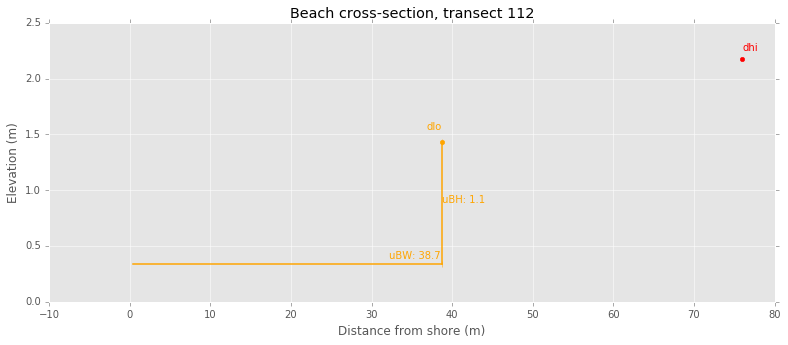

In [71]:
# View distribution of uBW values as descriptive stats and histogram.
fld = 'uBW'
print(pts_df[fld].describe())
pts_df[fld].hist()
plt.show()
plt.close('all')

# Randomly sample 5 rows
ran_samp = trans_df.sample(5)
ran_samp.loc[:,['SL_x', 'SL_y', 'DistDL', 'DL_zmhw', 'DistDH', 'DH_zmhw', 'DistArm', 'Arm_zmhw', 'uBW', 'uBH']]

# # For one row, plot the dlo, dhi position with uBW and uBH
# tran = ran_samp.iloc[0]

# # Beach detail
# fig = plt.figure(figsize=(13,5)) # Set the size of your figure, customize for more subplots
# ax = fig.add_subplot(111)

# # Subplot Labels
# ax.set_xlabel('Distance from shore (m)', fontsize = 12)
# ax.set_ylabel('Elevation (m)', fontsize = 12)
# ax.set_title('Beach cross-section, transect {}'.format(tran.name))

# # Beach points
# plt.scatter(tran.DistDL, tran.DL_z, color='orange')
# plt.annotate('dlo', xy=(tran.DistDL-tran.DistDL*0.05, tran.DL_z+tran.DL_z*0.08), color='orange')
# plt.scatter(tran.DistDH, tran.DH_z, color='red')
# plt.annotate('dhi', xy=(tran.DistDH-0.02, tran.DH_z+0.08), color='red')
# plt.scatter(tran.DistArm, tran.Arm_z, color='black')
# plt.annotate('armor', xy=(tran.DistArm-20, tran.Arm_z+0.5), color='black')

# # Upper beach width and height
# uBW = tran.uBW
# uBH = tran.uBH
# plt.plot([MHW, uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1.5)
# plt.annotate('uBW: {:.1f}'.format(uBW), xy=(uBW*0.83, MHW+0.05), color='orange')
# plt.plot([uBW, uBW],[MHW, MHW + uBH], color='orange', linestyle='-', linewidth = 1.5, marker='|')
# plt.annotate('uBH: {:.1f}'.format(uBH), xy=(uBW+0.03, MHW+uBH*0.5), color='orange')

# plt.show()
# plt.close('all')

### Dist2Inlet


Distance to nearest tidal inlet (__Dist2Inlet__) was computed as alongshore distance of each sampling transect from the nearest tidal inlet. This distance includes changes in the path of the shoreline rather than just a straight-line distance between each transect and the inlet and reflects sediment transport pathways. 

It was measured using the oceanside shoreline between inlets (ShoreBetweenInlets). Note that the ShoreBetweenInlets feature class must be both dissolved and singlepart so that each feature represents one-and-only-one shoreline that runs the entire distance between two inlets or equivalent. If the shoreline is bounded on both sides by an inlet, measure the distance to both and assign the minimum distance of the two. If the shoreline meets only one inlet (meaning the study area ends before the island ends), use the distance to the only inlet. This uses the cut, disjoint, and length geometry methods and properties in ArcPy data access module.

The function measure_Dist2Inlet() prints a warning when the difference in Dist2Inlet between two consecutive transects is greater than 300. 

In [5]:
# Calc Dist2Inlet in new dataframe 
dist_df = fwa.measure_Dist2Inlet(shoreline, extendedTrans, inletLines, tID_fld)

# Save
dist_df.to_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, dist_df, tID_fld, fill=fill)

Duration: 0:0:2.2 seconds


### Clip transects, get barrier widths
Calculates __WidthLand__, __WidthFull__, and __WidthPart__, which measure different flavors of the cross-shore width of the barrier island. __WidthLand__ is the above-water distance between the back-barrier and seaward MHW shorelines. __WidthLand__ only includes regions of the barrier within the shoreline polygon (bndpoly_2sl) and does not extend into any of the sinuous or intervening back-barrier waterways and islands. __WidthFull__ is the total distance between the back-barrier and seaward MHW shorelines (including space occupied by waterways). __WidthPart__ is the width of only the most seaward portion of land within the shoreline. 

These are calculated as follows: 

1. Clip the transect to the full island shoreline (Clip in the Analysis toolbox); 
2. For __WidthLand__, get the length of the multipart line segment from &quot;SHAPE@LENGTH&quot; feature class attribute. When the feature is multipart, this will include only the remaining portions of the transect; 
3. For __WidthPart__, convert the clipped transect from multipart to singlepart and get the length of the first line segment, which should be the most seaward; 
4. For __WidthFull__, calculate the distance between the first vertex and the last vertex of the clipped transect (Feature Class to NumPy Array with explode to points, pandas groupby, numpy hypot).

Temporary layers (assuming default names):

- clip2island
- clip2islandSingle_temp'

In [12]:
# Clip transects, get barrier widths *SPATIAL*
widths_df = fwa.calc_IslandWidths(extendedTrans, barrierBoundary, tID_fld=tID_fld)

# Save
widths_df.to_pickle(os.path.join(scratch_dir, 'widths_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, widths_df, tID_fld, fill=fill)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))
# trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))

Clipping the transects to the barrier island boundaries...
Getting the width along each transect of the oceanside land (WidthPart)...
Converting feature class to array...
Converting array to dataframe...
Getting the width along each transect of the entire barrier (WidthFull)...
Converting feature class vertices to array with X and Y...
Converting array to dataframe...
Getting the width along each transect of above water portion of the barrier (WidthLand)...


## 5-m Points
The point dataset samples the land every 5 m along each shore-normal transect. 

### Split transects into points at 5-m intervals. 

It is created from the tidied transects (tidyTrans, created during pre-processing) as follows: 

1. Clip the tidied transects (tidyTrans) to the shoreline polygon (bndpoly_2sl) , retaining only those portions of the transects that represent land.
2. Produce a dataframe of point positions along each transect every 5 m starting from the ocean-side shoreline. This uses the positionAlongLine geometry method accessed witha Search Cursor and saves the outputs in a new dataframe. 
3. Create a point feature class from the dataframe. 

Temporary files: 
- tran5mPts_unsorted

In [13]:
# if os.path.exists(os.path.join(scratch_dir, transPts_null+'.pkl')):
#     pts_df = pd.read_pickle(os.path.join(scratch_dir,transPts_null+'.pkl'))
#     trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))

pts_df, transPts_presort = fwa.TransectsToPointsDF(extTrans_tidy, barrierBoundary, fc_out=transPts_presort) # 4 minutes for FireIsland

Getting points every 5m along each transect and saving in dataframe...
Converting new dataframe to feature class...
Duration: 0:1:25.1 seconds


### Add Elevation and Slope to points

__ptZmhw__ and __ptSlp__ are the elevation and slope at the 5-m cell corresponding to the point. 
1. Create the slope and DEM rasters if they don't already exist. We use the 5-m DEM to generate a slope surface (Slope tool in 3D Analyst). 
2. Use Extract Multi Values to Points tool in Spatial Analyst. 
3. Convert the feature class back to a dataframe

In [15]:
# Create elevation and slope rasters at 5-m resolution
if not arcpy.Exists(elevGrid_5m):
    fwa.ProcessDEM(elevGrid, elevGrid_5m, utmSR)
if not arcpy.Exists(slopeGrid):
    arcpy.Slope_3d(elevGrid_5m, slopeGrid, 'PERCENT_RISE')
    
# Add elevation and slope values at points.
arcpy.sa.ExtractMultiValuesToPoints(transPts_presort, 
                                    [[elevGrid_5m, 'ptZ'], [slopeGrid, 'ptSlp']])

# Convert to dataframe
pts_df = fwa.FCtoDF(transPts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp'])

# Save
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_df_elev_slope.pkl'))

# View 10 randomly selected rows 
pts_df.sample(10)

<geoprocessing server result object at 0xba33e90>

In [ ]:
# Add elevation and slope values at points.
arcpy.sa.ExtractMultiValuesToPoints(transPts_presort, [[SubType, 'SubType'], [VegType, 'VegType'], 
                                                       [VegDens, 'VegDens'], [GeoSet, 'GeoSet']])

             SHAPE@X       SHAPE@Y      ptSlp       ptZ  sort_ID
16400  414685.027333  4.106134e+06   0.383884  0.536026     72.0
32943  414774.532546  4.104706e+06  10.563998  1.443349     92.0
34225  415382.240998  4.104563e+06   0.866908  0.253785    106.0
27535  415283.864008  4.105445e+06   2.174363  0.466509    110.0
29145  416116.957945  4.105166e+06   0.749029  2.494718    127.0
5573   413104.546023  4.106557e+06   5.570257  2.075946     26.0
23786  413984.894041  4.105352e+06   0.823320  0.439946     68.0
8626   414941.658032  4.106328e+06   0.266593  0.240249    164.0
34612  415525.703015  4.104757e+06   3.275535  1.749567    110.0
5960   413164.351575  4.106476e+06   2.984524  1.331310     28.0
             SHAPE@X       SHAPE@Y         ptSlp           ptZ       sort_ID
count   35358.000000  3.535800e+04  35308.000000  35328.000000  35358.000000
mean   414611.466302  4.105918e+06      2.946486      0.817946     97.226597
std       943.662526  7.280979e+02      3.222569      

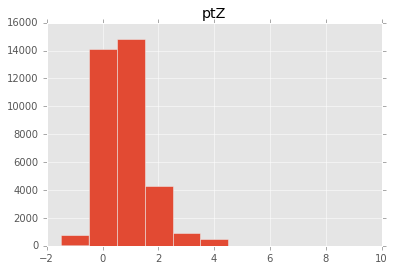

In [23]:
pts_df = pd.read_pickle(os.path.join(scratch_dir, 'pts_df_elev_slope.pkl'))
print(pts_df.describe([]))

pts_df.hist('ptZ')
plt.show()
plt.close()

In [6]:
pts_df = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))
# trans_df = pd.read_pickle(os.path.join(scratch_dir,  trans_name+'_null.pkl'))
pts_df.sample(10)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
43696,43696,667926.5019,4.505330e+06,174.999964,11.729786,132.445227,138.467364,NaN,3.237360,34.877926,...,186.729750,186.729750,35.253977,3.080359,DL,2.370706,4.834906,111.0,111.0,222.0
29966,29966,657328.6978,4.501255e+06,14.999987,348.216048,-53.079463,-38.117806,-22.639178,1.598481,4.924788,...,363.216035,363.216035,47.376653,2.211361,DL,1.222268,3.124422,222.0,333.0,222.0
58916,58916,675630.8652,4.509763e+06,605.930518,-171.183765,528.143847,NaN,NaN,0.413410,0.484665,...,753.641287,779.571782,73.912510,2.264014,DH,0.521648,2.707652,111.0,111.0,222.0
14524,14524,649537.9000,4.499050e+06,230.000000,350.970242,141.831932,NaN,153.116330,4.522293,0.357436,...,580.970242,580.970242,76.883670,4.100922,Arm,3.004647,6.152883,222.0,222.0,222.0
61111,61111,676634.2040,4.509612e+06,0.000000,303.740686,-23.231768,-17.143871,NaN,0.348281,3.662439,...,638.631995,713.872411,16.657145,1.868806,DL,0.192224,4.023687,111.0,111.0,222.0
35875,35875,661007.7657,4.502554e+06,145.000027,77.274170,57.989182,88.363377,NaN,1.063250,3.190768,...,222.274197,222.274197,54.384907,2.462617,DL,1.551551,4.868765,111.0,111.0,222.0
42663,42663,666923.7032,4.504757e+06,104.714545,97.570675,NaN,NaN,NaN,5.992540,1.942163,...,202.285220,202.285220,NaN,NaN,NaN,2.511594,5.706742,111.0,111.0,222.0
26702,26702,655656.8196,4.501065e+06,304.999976,335.144350,258.930567,NaN,267.744863,1.906724,14.397382,...,640.144326,640.144326,37.255114,2.579198,Arm,1.080571,3.804972,222.0,333.0,222.0
46600,46600,670060.4901,4.506314e+06,84.999973,433.562214,23.596130,31.961538,NaN,2.796177,14.127097,...,518.562187,518.562187,52.750688,4.191166,DL,0.959709,7.151576,111.0,222.0,222.0
91031,91031,693066.6191,4.516636e+06,255.000072,89.925418,NaN,NaN,NaN,1.415048,4.202951,...,344.925490,344.925490,NaN,NaN,NaN,1.347377,4.682235,NaN,NaN,NaN


### Calculate distances and sort points

__SplitSort__ is a unique numeric identifier of the 5-m points at the study site, sorted by order along shoreline and by distance from oceanside. __SplitSort__ values are populated by sorting the points by __sort_ID__ and __Dist_Seg__ (see below). 

__Dist_Seg__ is the Euclidean distance between the point and the seaward shoreline (__SL_x__, __SL_y__). __Dist_MHWbay__ is the distance between the point and the bayside shoreline and is calculated by subtracting the __Dist_Seg__ value from the __WidthPart__ value of the transect. 

__DistSegDH__, __DistSegDL__, and __DistSegArm__ measure the distance of each 5-m point from the dune crest and dune toe position along a particular transect. They are calculated as the Euclidean distance between the 5-m point and the given feature. 

In [28]:
sorted_pt_flds = ['SplitSort', 'seg_x', 'seg_y',
    'Dist_Seg', 'Dist_MHWbay', 'DistSegDH', 'DistSegDL', 'DistSegArm',
    'ptZ', 'ptSlp', 'ptZmhw',
    'GeoSet', 'SubType', 'VegDens', 'VegType',
    'sort_ID','TRANSORDER', 'TRANSECTID', 'DD_ID', 'AZIMUTH',
    'LRR', 'SL_x', 'SL_y', 'Bslope',
    'DL_x', 'DL_y', 'DL_z', 'DL_zmhw', 'DL_snapX','DL_snapY',
    'DH_x', 'DH_y', 'DH_z', 'DH_zmhw', 'DH_snapX','DH_snapY',
    'Arm_x', 'Arm_y', 'Arm_z', 'Arm_zmhw',
    'DistDH', 'DistDL', 'DistArm',
    'Dist2Inlet', 'WidthPart', 'WidthLand', 'WidthFull',
    'uBW', 'uBH', 'ub_feat', 'mean_Zmhw', 'max_Zmhw',
    'Construction', 'Development', 'Nourishment']

In [29]:
# Calculate DistSeg, Dist_MHWbay, DistSegDH, DistSegDL, DistSegArm, and sort points (SplitSort)
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)
pts_df = fun.prep_points(pts_df, tID_fld, pID_fld, sitevals['MHW'], fill)

# Aggregate ptZmhw to max and mean and join to transects
pts_df, zmhw = fun.aggregate_z(pts_df, sitevals['MHW'], tID_fld, 'ptZ', fill)
trans_df = fun.join_columns(trans_df, zmhw) 

# Join transect values to pts
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)

# pID_fld needs to be among the columns
if not pID_fld in pts_df.columns:
    pts_df.reset_index(drop=False, inplace=True)

# Drop extra fields and sort columns
trans_df.drop(extra_fields, axis=1, inplace=True, errors='ignore')
pts_df = pts_df.reindex_axis(sorted_pt_flds, axis=1)

# Save dataframes 
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

# View random rows from the points DF
pts_df.sample(5)

SplitSort already existed in dataframe, but it was replaced.


,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
28056,28056,656055.2263,4.501460e+06,570.000028,54.129091,NaN,NaN,540.673977,0.684839,1.852051,...,624.129119,624.129119,29.326051,3.115282,Arm,0.958493,5.416284,222.0,333.0,222.0
24437,24437,654203.4210,4.500521e+06,210.000014,120.875242,140.171326,153.893991,153.619807,1.481722,1.213977,...,330.875256,330.875256,55.914288,2.330598,DL,1.193224,4.676314,222.0,333.0,222.0
16620,16620,650582.8929,4.499394e+06,260.000033,180.580380,NaN,NaN,NaN,0.798894,4.042883,...,440.580413,440.580413,NaN,NaN,NaN,0.813399,1.944304,111.0,222.0,222.0
2671,2671,643663.8665,4.498515e+06,460.000049,387.287348,404.893179,413.626226,NaN,1.112670,1.082971,...,847.287397,847.287397,46.294090,2.802423,DL,1.215566,5.689978,333.0,111.0,222.0
51058,51058,672402.6540,4.507684e+06,204.999972,147.607889,133.027001,156.601654,NaN,1.008128,3.744787,...,352.607862,352.607862,47.257235,2.990057,DL,1.345031,6.266856,111.0,111.0,222.0


In [30]:
pts_df.columns

Index(['SplitSort', 'seg_x', 'seg_y', 'Dist_Seg', 'Dist_MHWbay', 'DistSegDH',
       'DistSegDL', 'DistSegArm', 'ptZ', 'ptSlp', 'ptZmhw', 'GeoSet',
       'SubType', 'VegDens', 'VegType', 'sort_ID', 'TRANSORDER', 'TRANSECTID',
       'DD_ID', 'AZIMUTH', 'LRR', 'SL_x', 'SL_y', 'Bslope', 'DL_x', 'DL_y',
       'DL_z', 'DL_zmhw', 'DL_snapX', 'DL_snapY', 'DH_x', 'DH_y', 'DH_z',
       'DH_zmhw', 'DH_snapX', 'DH_snapY', 'Arm_x', 'Arm_y', 'Arm_z',
       'Arm_zmhw', 'DistDH', 'DistDL', 'DistArm', 'Dist2Inlet', 'WidthPart',
       'WidthLand', 'WidthFull', 'uBW', 'uBH', 'ub_feat', 'mean_Zmhw',
       'max_Zmhw', 'Construction', 'Development', 'Nourishment'],
      dtype='object')

In [32]:
pts_df.AZIMUTH

0        358.75
1        358.75
2        358.75
3        358.75
4        358.75
5        358.75
6        358.75
7        358.75
8        358.75
9        358.75
10       358.75
11       358.75
12       358.75
13       358.75
14       358.75
15       358.75
16       358.75
17       358.75
18       358.75
19       358.75
20       358.75
21       358.75
22       358.75
23       358.75
24       358.75
25       358.75
26       358.75
27       358.75
28       358.75
29       358.75
          ...  
91258    338.27
91259    338.27
91260    338.27
91261    338.27
91262    338.27
91263    338.27
91264    338.27
91265    338.27
91266    338.27
91267    338.27
91268    338.27
91269    338.27
91270    338.27
91271    338.27
91272    338.27
91273    338.27
91274    338.27
91275    338.27
91276    338.27
91277    338.27
91278    338.27
91279    338.27
91280    338.27
91281    338.27
91282    338.27
91283    338.27
91284    338.27
91285    338.27
91286    338.27
91287    338.27
Name: AZIMUTH, Length: 9

### Recode the values for CSV output and model running

In [33]:
# Recode
pts_df4csv = pts_df.replace({'SubType': {7777:'{1111, 2222}', 1000:'{1111, 3333}'}, 
                              'VegType': {77:'{11, 22}', 88:'{22, 33}', 99:'{33, 44}'},
                              'VegDens': {666: '{111, 222}', 777: '{222, 333}', 
                                          888: '{333, 444}', 999: '{222, 333, 444}'}})

# Fill NAs
pts_df4csv.fillna(fill, inplace=True) 

# Save and view sample
pts_df4csv.to_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df4csv.sample(5)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
6776,6776,645366.9044,4.498394e+06,304.999968,181.419065,225.645214,239.303969,229.313261,3.845294,1.609700,...,486.419033,486.419033,64.258821,2.893960,DL,3.482500,5.435715,222.0,333.0,222.0
10170,10170,647564.3769,4.498534e+06,145.000000,152.119794,-99999.000000,-99999.000000,88.406834,4.432531,0.586790,...,297.119795,297.119795,56.593166,2.344929,Arm,2.693991,4.252560,222.0,222.0,222.0
77402,77402,686594.7371,4.514401e+06,444.999971,87.833579,367.480084,378.681033,-99999.000000,0.195108,0.168690,...,782.689894,890.408184,66.139896,3.931727,DL,0.264112,6.698621,111.0,111.0,222.0
3769,3769,643960.5437,4.498671e+06,629.999997,174.389292,556.195968,567.432279,-99999.000000,1.502596,4.171125,...,804.389289,804.389289,62.506162,2.916580,DL,1.293806,5.162872,111.0,111.0,222.0
76108,76108,686250.0171,4.514193e+06,345.000043,366.961032,300.575062,306.459884,-99999.000000,0.141771,1.972222,...,711.961075,711.961075,35.760759,2.873289,DL,0.105259,4.888779,111.0,111.0,222.0


## Quality checking
Look at extracted profiles from around the island. Entered the transect ID within the available range when prompted. Evaluated the plots for consistency among variables. Repeat various times until you can be satisfied that the variables are consistent with each other and appear to represent reality.

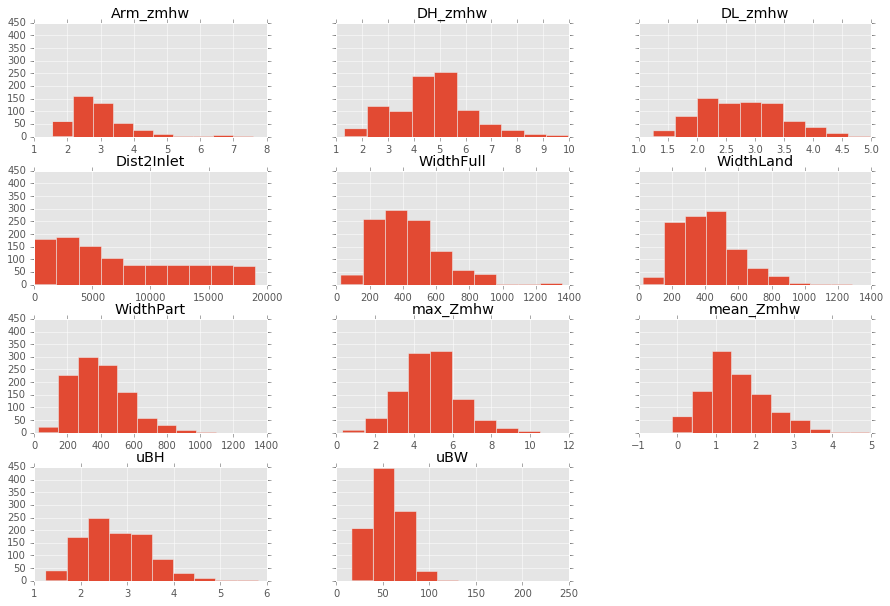

In [21]:
desccols = ['DL_zmhw', 'DH_zmhw', 'Arm_zmhw', 'uBW', 'uBH', 'Dist2Inlet', 
            'WidthPart', 'WidthLand', 'WidthFull', 'mean_Zmhw', 'max_Zmhw']
trans_df.loc[:,desccols].describe()
trans_df.hist(desccols, sharey=True, figsize=[15, 10])
plt.show()
plt.close('all')

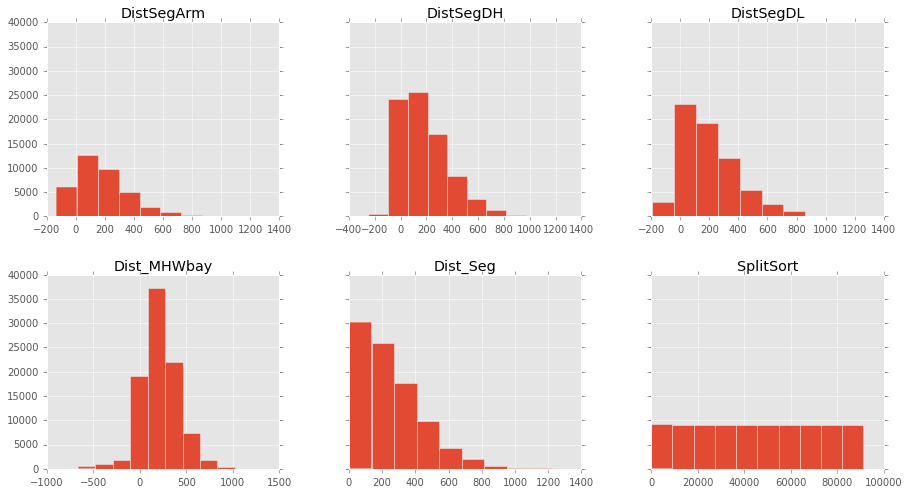

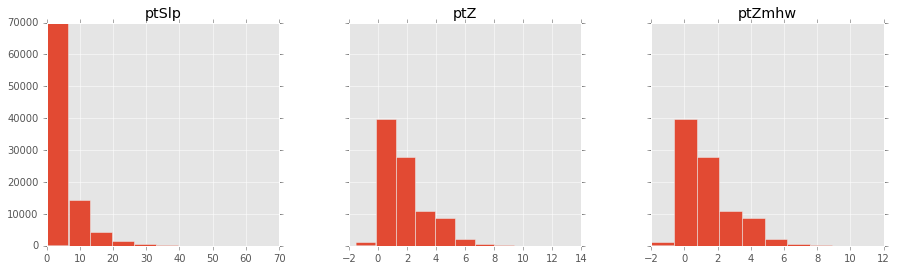

In [22]:
flds_dist = ['SplitSort', 'Dist_Seg', 'Dist_MHWbay', 'DistSegDH', 'DistSegDL', 'DistSegArm']
flds_z = ['ptZmhw', 'ptZ', 'ptSlp']
pts_df.loc[:,flds_dist+flds_z].describe()
pts_df.hist(flds_dist, sharey=True, figsize=[15, 8], layout=(2,3))
pts_df.hist(flds_z, sharey=True, figsize=[15, 4], layout=(1,3))
plt.show()
plt.close('all')

Transect ID ("sort_ID" 1-1102): 900


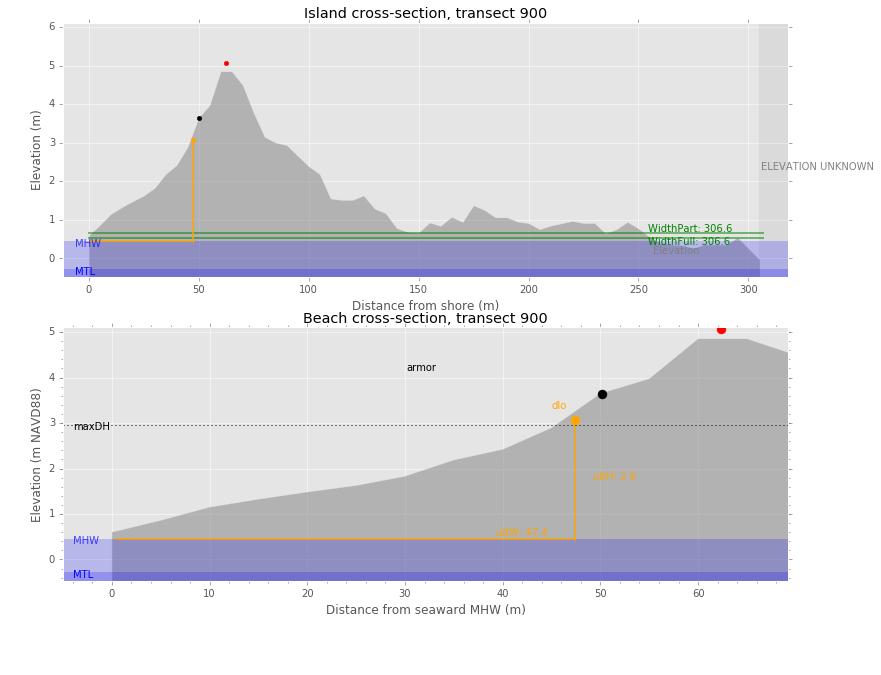

In [23]:
# Prompt for transect identifier (sort_ID) and get all points from that transect.
trans_in = int(input('Transect ID ("sort_ID" {:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

# Plot
fig = plt.figure(figsize=(13,10))

# Plot the width of the island.
ax1 = fig.add_subplot(211)
fun.plot_island_profile(ax1, pts_set, MHW, MTL)

# Zoom in on the upper beach.
ax2 = fig.add_subplot(212)
fun.plot_beach_profile(ax2, pts_set, MHW, MTL, maxDH)

# Display
plt.show()
plt.close('all')

## Outputs

### Transect-averaged
#### Vector format

In [ ]:
# Create transect FC with fill values - Join values from trans_df to the transect FC as a new file.
trans_fc = fwa.JoinDFtoFC(trans_df, extendedTrans, tID_fld, out_fc=extTrans_fill)

# Create transect FC with null values
fwa.CopyFCandReplaceValues(trans_fc, fill, None, out_fc=extTrans_null, out_dir=home)

# Save final transect SHP with fill values
arcpy.FeatureClassToFeatureClass_conversion(trans_fc, scratch_dir, extTrans_shp+'.shp')

#### Raster - beach width

In [26]:
# Create a template raster corresponding to the transects. 
if not arcpy.Exists(rst_transIDpath):
    outEucAll = arcpy.sa.EucAllocation(extTrans_tidy, maximum_distance=50, cell_size=cell_size, source_field=tID_fld)
    outEucAll.save(os.path.basename(rst_transIDpath))

# Create raster of uBW values by joining trans_df to the template raster.
out_rst = fwa.JoinDFtoRaster(trans_df, rst_transID, bw_rst, fill, tID_fld, 'uBW')

OUTPUT: fish14_ubw. Field "Value" is ID and "uBW" is beachwidth.


### 5-m points
#### Tabular format
Save final pts with fill values as CSV

In [35]:
# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, pts_name +'.csv')
pts_df4csv.to_csv(csv_fname, na_rep=fill, index=False)
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(csv_fname)))

OUTPUT: fiis14_pts.csv in specified scratch_dir.


#### Vector format

In [ ]:
# Convert pts_df to FC - automatically converts NaNs to fills (default fill is -99999)
pts_fc = fwa.DFtoFC_large(pts_df, out_fc=os.path.join(arcpy.env.workspace, pts_name+'_fill'), 
                          spatial_ref=utmSR, df_id=pID_fld, xy=["seg_x", "seg_y"])

# Save final FCs with null values
fwa.CopyFCandReplaceValues(pts_fc, fill, None, out_fc=pts_name+'_null', out_dir=home)

# Save final points as SHP with fill values
out_pts_shp = arcpy.FeatureClassToFeatureClass_conversion(pts_fc, scratch_dir, pts_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_pts_shp))))

Converting points DF to FC...
... converting dataframe to array... 
... converting array to feature class... 



In [34]:
print('{}{} -- Number of points in dataset: {}'.format(site, year, pts_df4csv.shape))
for fld in pts_df4csv.columns:
    if fld in ['GeoSet', 'SubType', 'VegDens', 'VegType', 'Construction', 'Development', 'Nourishment', 'ub_feat']:
        print('{} values: {}'.format(fld, '  |  '.join(str(x) for x in pts_df4csv.loc[:,fld].unique())))
    else:
        if not any(pd.isnull(pts_df4csv.loc[:,fld])):
            mn = min(pts_df4csv.loc[:,fld])
        else:
            mn = -99999
        mx = np.max(pts_df4csv.loc[:,fld])
        print('{} min|max: {}  |  {}'.format(fld, mn, mx))

FireIsland2014 -- Number of points in dataset: (91288, 55)
SplitSort min|max: 0  |  91287
seg_x min|max: -99999.0  |  693300.5998
seg_y min|max: -99999.0  |  4516968.503900001
Dist_Seg min|max: -99999.0  |  1359.559068327002
Dist_MHWbay min|max: -99999.0  |  1210.5718634452955
DistSegDH min|max: -99999.0  |  1270.6643468930165
DistSegDL min|max: -99999.0  |  1308.1615868720996
DistSegArm min|max: -99999.0  |  1300.7735586442
ptZ min|max: -99999.0  |  12.099376678466797
ptSlp min|max: -99999.0  |  66.01898956298828
ptZmhw min|max: -99999.0  |  11.639376640319824
GeoSet values: -99999.0
SubType values: -99999.0
VegDens values: -99999.0
VegType values: -99999.0
sort_ID min|max: 1.0  |  1102.0
TRANSORDER min|max: -99999.0  |  2057.0
TRANSECTID min|max: -99999.0  |  4049.0
DD_ID min|max: 10001  |  11102
AZIMUTH min|max: 335.43  |  358.75
LRR min|max: -2.37  |  12.01
SL_x min|max: -99999.0  |  693300.5998
SL_y min|max: -99999.0  |  4516453.9901
Bslope min|max: -99999.0  |  -0.002302
DL_x min